# NEST implementation of the `aeif` models

#### Hans Ekkehard Plesser and Tanguy Fardet, 2016-09-09
#### Updated by Hans Ekkehard Plesser, 2023-08-25

This notebook provides a reference solution for the _Adaptive Exponential Integrate and Fire_
(AEIF) neuronal model and compares it with several numerical implementations using simpler solvers.
In particular this justifies the change of implementation in September 2016 to make the simulation
closer to the reference solution.

## Position of the problem

### Basics
The equations governing the evolution of the AEIF model are

$$\left\lbrace\begin{array}{rcl}
    C_m\dot{V} &=& -g_L(V-E_L) + g_L \Delta_T e^{\frac{V-V_T}{\Delta_T}} + I_e + I_s(t) -w\\
    \tau_s\dot{w} &=& a(V-E_L) - w
\end{array}\right.$$

when $V < V_{peak}$ (threshold/spike detection).
Once a spike occurs, we apply the reset conditions:

$$V = V_r \quad \text{and} \quad w = w + b$$

### Divergence
In the AEIF model, the spike is generated by the exponential divergence. In practice, this means that just before threshold crossing (threshpassing), the argument of the exponential can become very large.

This can lead to numerical overflow or numerical instabilities in the solver, all the more if $V_{peak}$ is large, or if $\Delta_T$ is small.

## Tested solutions

### Old implementation (before September 2016)
The original solution was to bind the exponential argument to be smaller than 10 (ad hoc value to be close to the original implementation in BRIAN).
As will be shown in the notebook, this solution does not converge to the reference LSODAR solution.

### New implementation
The new implementation does not bind the argument of the exponential, but the potential itself, since according to the theoretical model, $V$ should never get larger than $V_{peak}$.
We will show that this solution is not only closer to the reference solution in general, but also converges towards it as the timestep gets smaller.

## Reference solution

The reference solution is implemented using the LSODAR solver which is described and compared in the following references:

* Shampine LF, and Thompson S. (2000). Event location for ordinary differential equations. Computers and Mathematics with Applications, 39(5–6), 43–54. https://doi.org/10.1016/S0898-1221(00)00045-6 
* Thompson S (1987). A collection of test problems for ordinary differential equation solvers which have provisions for rootfinding (ORNL/TM-9912, 6111421; p. ORNL/TM-9912, 6111421). https://doi.org/10.2172/6111421 
* Dieci L, and Lopez L (2012). A survey of numerical methods for IVPs of ODEs with discontinuous right-hand side. Journal of Computational and Applied Mathematics, 236(16), 3967–3991. https://doi.org/10.1016/j.cam.2012.02.011 
* Hindmarsh, AC (1983). ODEPACK, a systematized collection of ODE solvers. In R. S. Stepleman & others (Eds.), Scientific computing (Vol. 1, pp. 55–64). North-Holland. https://computing.llnl.gov/sites/default/files/u88007.pdf 
* Petzold L. (1983). Automatic Selection of Methods for Solving Stiff and Nonstiff Systems of Ordinary Differential Equations. SIAM Journal on Scientific and Statistical Computing, 4(1), 136–148. https://doi.org/10.1137/0904010 
* Kahaner DK, Lawkins WF, and Thompson S. (1989). On the use of rootfinding ODE software for the solution of a common problem in nonlinear dynamical systems. Journal of Computational and Applied Mathematics, 28, 219–230. https://doi.org/10.1016/0377-0427(89)90334-8 


## Technical details and requirements

### Implementation of the functions

* The old and new implementations are reproduced using Scipy and are called by the ``scipy_aeif`` function
* The NEST implementations are not shown here, but keep in mind that for a given time resolution, they are closer to the reference result than the scipy implementation since the GSL implementation uses a RK45 adaptive solver.
* The reference solution using LSODAR, called ``reference_aeif``, is implemented through the [assimulo](http://www.jmodelica.org/assimulo) package.

### Requirements

To run this notebook, you need:

* [numpy](http://www.numpy.org/) and [scipy](http://www.scipy.org/)
* [assimulo](http://www.jmodelica.org/assimulo)
* [matplotlib](http://matplotlib.org/)

The assimulo package from PyPI is quite old and cannot be installed with current versions of Python distribution tools. If you use conda/mamba, you can install a current version of Assimulo from `conda-forge`. We have tested this notebook with assimulo 3.4.1.

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 6)

## Scipy functions mimicking the NEST code
### Right hand side functions

In [2]:
def rhs_aeif_new(y, _, p):
    """
    New implementation bounding V < V_peak

    Parameters
    ----------
    y : list
        Vector containing the state variables [V, w]
    _ : unused var
    p : Params instance
        Object containing the neuronal parameters.

    Returns
    -------
    dv : double
        Derivative of V
    dw : double
        Derivative of w
    """
    v = min(y[0], p.Vpeak)
    w = y[1]
    Ispike = 0.0

    if p.DeltaT != 0.0:
        Ispike = p.gL * p.DeltaT * np.exp((v - p.vT) / p.DeltaT)

    dv = (-p.gL * (v - p.EL) + Ispike - w + p.Ie) / p.Cm
    dw = (p.a * (v - p.EL) - w) / p.tau_w

    return dv, dw


def rhs_aeif_old(y, _, p):
    """
    Old implementation bounding the argument of the
    exponential function (e_arg < 10.).

    Parameters
    ----------
    y : list
        Vector containing the state variables [V, w]
    _ : unused var
    p : Params instance
        Object containing the neuronal parameters.

    Returns
    -------
    dv : double
        Derivative of V
    dw : double
        Derivative of w
    """
    v = y[0]
    w = y[1]
    Ispike = 0.0

    if p.DeltaT != 0.0:
        e_arg = min((v - p.vT) / p.DeltaT, 10.0)
        Ispike = p.gL * p.DeltaT * np.exp(e_arg)

    dv = (-p.gL * (v - p.EL) + Ispike - w + p.Ie) / p.Cm
    dw = (p.a * (v - p.EL) - w) / p.tau_w

    return dv, dw

### Complete model

In [3]:
def scipy_aeif(p, f, simtime, dt):
    """
    Complete aeif model using scipy `odeint` solver.

    Parameters
    ----------
    p : Params instance
        Object containing the neuronal parameters.
    f : function
        Right-hand side function (either `rhs_aeif_old`
        or `rhs_aeif_new`)
    simtime : double
        Duration of the simulation (will run between
        0 and tmax)
    dt : double
        Time increment.

    Returns
    -------
    t : list
        Times at which the neuronal state was evaluated.
    y : list
        State values associated to the times in `t`
    s : list
        Spike times.
    vs : list
        Values of `V` just before the spike.
    ws : list
        Values of `w` just before the spike
    fos : list
        List of dictionaries containing additional output
        information from `odeint`
    """
    t = np.arange(0, simtime, dt)  # time axis
    n = len(t)
    y = np.zeros((n, 2))  # V, w
    y[0, 0] = p.EL  # Initial: (V_0, w_0) = (E_L, 5.)
    y[0, 1] = 5.0  # Initial: (V_0, w_0) = (E_L, 5.)
    s = []  # spike times
    vs = []  # membrane potential at spike before reset
    ws = []  # w at spike before step
    fos = []  # full output dict from odeint()

    # imitate NEST: update time-step by time-step
    for k in range(1, n):
        # solve ODE from t_k-1 to t_k
        d, fo = odeint(f, y[k - 1, :], t[k - 1 : k + 1], (p,), full_output=True)
        y[k, :] = d[1, :]
        fos.append(fo)

        # check for threshold crossing
        if y[k, 0] >= p.Vpeak:
            s.append(t[k])
            vs.append(y[k, 0])
            ws.append(y[k, 1])

            y[k, 0] = p.Vreset  # reset
            y[k, 1] += p.b  # step

    return t, y, s, vs, ws, fos

## LSODAR reference solution
### Setting assimulo class

In [4]:
from assimulo.solvers import LSODAR
from assimulo.problem import Explicit_Problem


class Extended_Problem(Explicit_Problem):
    # need variables here for access
    sw0 = [False]
    ts_spikes = []
    ws_spikes = []
    Vs_spikes = []

    def __init__(self, p):
        self.p = p
        self.y0 = [self.p.EL, 5.0]  # V, w
        # reset variables
        self.ts_spikes = []
        self.ws_spikes = []
        self.Vs_spikes = []

    # The right-hand-side function (rhs)

    def rhs(self, t, y, sw):
        """
        This is the function we are trying to simulate (aeif model).
        """
        V, w = y[0], y[1]
        Ispike = 0.0

        if self.p.DeltaT != 0.0:
            Ispike = self.p.gL * self.p.DeltaT * np.exp((V - self.p.vT) / self.p.DeltaT)
        dotV = (-self.p.gL * (V - self.p.EL) + Ispike + self.p.Ie - w) / self.p.Cm
        dotW = (self.p.a * (V - self.p.EL) - w) / self.p.tau_w
        return np.array([dotV, dotW])

    # Sets a name to our function
    name = "AEIF_nosyn"

    # The event function
    def state_events(self, t, y, sw):
        """
        This is our function that keeps track of our events. When the sign
        of any of the events has changed, we have an event.
        """
        event_0 = -5 if y[0] >= self.p.Vpeak else 5  # spike
        if event_0 < 0:
            if not self.ts_spikes:
                self.ts_spikes.append(t)
                self.Vs_spikes.append(y[0])
                self.ws_spikes.append(y[1])
            elif self.ts_spikes and not np.isclose(t, self.ts_spikes[-1], 0.01):
                self.ts_spikes.append(t)
                self.Vs_spikes.append(y[0])
                self.ws_spikes.append(y[1])
        return np.array([event_0])

    # Responsible for handling the events.
    def handle_event(self, solver, event_info):
        """
        Event handling. This functions is called when Assimulo finds an event as
        specified by the event functions.
        """
        ev = event_info
        event_info = event_info[0]  # only look at the state events information.
        if event_info[0] > 0:
            solver.sw[0] = True
            solver.y[0] = self.p.Vreset
            solver.y[1] += self.p.b
        else:
            solver.sw[0] = False

    def initialize(self, solver):
        solver.h_sol = []
        solver.nq_sol = []

    def handle_result(self, solver, t, y):
        Explicit_Problem.handle_result(self, solver, t, y)
        # Extra output for algorithm analysis
        if solver.report_continuously:
            h, nq = solver.get_algorithm_data()
            solver.h_sol.extend([h])
            solver.nq_sol.extend([nq])

### LSODAR reference model

In [5]:
def reference_aeif(p, simtime):
    """
    Reference aeif model using LSODAR.

    Parameters
    ----------
    p : Params instance
        Object containing the neuronal parameters.
    f : function
        Right-hand side function (either `rhs_aeif_old`
        or `rhs_aeif_new`)
    simtime : double
        Duration of the simulation (will run between
        0 and tmax)
    dt : double
        Time increment.

    Returns
    -------
    t : list
        Times at which the neuronal state was evaluated.
    y : list
        State values associated to the times in `t`
    s : list
        Spike times.
    vs : list
        Values of `V` just before the spike.
    ws : list
        Values of `w` just before the spike
    h : list
        List of the minimal time increment at each step.
    """
    # Create an instance of the problem
    exp_mod = Extended_Problem(p)  # Create the problem
    exp_sim = LSODAR(exp_mod)  # Create the solver

    exp_sim.atol = 1.0e-8
    exp_sim.report_continuously = True
    exp_sim.store_event_points = True

    exp_sim.verbosity = 30

    # Simulate
    t, y = exp_sim.simulate(simtime)  # Simulate 10 seconds

    return t, y, exp_mod.ts_spikes, exp_mod.Vs_spikes, exp_mod.ws_spikes, exp_sim.h_sol

## Set the parameters and simulate the models
### Params (chose a dictionary)

In [6]:
# Regular spiking
aeif_param = {
    "V_reset": -58.0,
    "V_peak": 0.0,
    "V_th": -50.0,
    "I_e": 420.0,
    "g_L": 11.0,
    "tau_w": 300.0,
    "E_L": -70.0,
    "Delta_T": 2.0,
    "a": 3.0,
    "b": 0.0,
    "C_m": 200.0,
    "V_m": -70.0,  #! must be equal to E_L
    "w": 5.0,  #! must be equal to 5.
    "tau_syn_ex": 0.2,
}

# Bursting
aeif_param2 = {
    "V_reset": -46.0,
    "V_peak": 0.0,
    "V_th": -50.0,
    "I_e": 500.0,
    "g_L": 10.0,
    "tau_w": 120.0,
    "E_L": -58.0,
    "Delta_T": 2.0,
    "a": 2.0,
    "b": 100.0,
    "C_m": 200.0,
    "V_m": -58.0,  #! must be equal to E_L
    "w": 5.0,  #! must be equal to 5.
}

# Close to chaos (use resolution < 0.005 and simtime = 200)
aeif_param3 = {
    "V_reset": -48.0,
    "V_peak": 0.0,
    "V_th": -50.0,
    "I_e": 160.0,
    "g_L": 12.0,
    "tau_w": 130.0,
    "E_L": -60.0,
    "Delta_T": 2.0,
    "a": -11.0,
    "b": 30.0,
    "C_m": 100.0,
    "V_m": -60.0,  #! must be equal to E_L
    "w": 5.0,  #! must be equal to 5.
}


class Params:
    """
    Class giving access to the neuronal
    parameters.
    """

    def __init__(self):
        self.params = aeif_param
        self.Vpeak = aeif_param["V_peak"]
        self.Vreset = aeif_param["V_reset"]
        self.gL = aeif_param["g_L"]
        self.Cm = aeif_param["C_m"]
        self.EL = aeif_param["E_L"]
        self.DeltaT = aeif_param["Delta_T"]
        self.tau_w = aeif_param["tau_w"]
        self.a = aeif_param["a"]
        self.b = aeif_param["b"]
        self.vT = aeif_param["V_th"]
        self.Ie = aeif_param["I_e"]


p = Params()

### Simulate the 3 implementations

In [7]:
# Parameters of the simulation
simtime = 100.0
resolution = 0.01

t_old, y_old, s_old, vs_old, ws_old, fo_old = scipy_aeif(p, rhs_aeif_old, simtime, resolution)
t_new, y_new, s_new, vs_new, ws_new, fo_new = scipy_aeif(p, rhs_aeif_new, simtime, resolution)
t_ref, y_ref, s_ref, vs_ref, ws_ref, h_ref = reference_aeif(p, simtime)

Final Run Statistics: AEIF_nosyn 

 Number of steps                       : 2013
 Number of function evaluations        : 5590
 Number of Jacobian evaluations        : 0
 Number of state function evaluations  : 2042
 Number of state events                : 7

Solver options:

 Solver                  : LSODAR 
 Absolute tolerances     : [1.e-08 1.e-08]
 Relative tolerances     : 1e-06
 Starter                 : classical

Simulation interval    : 0.0 - 100.0 seconds.
Elapsed simulation time: 0.06999148603063077 seconds.


/var/folders/5k/0gyqhsf50418tc1x1l1t5lsw0000gn/T/ipykernel_86976/3648738050.py:44: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  t, y = exp_sim.simulate(simtime)  # Simulate 10 seconds


## Plot the results
### Zoom out

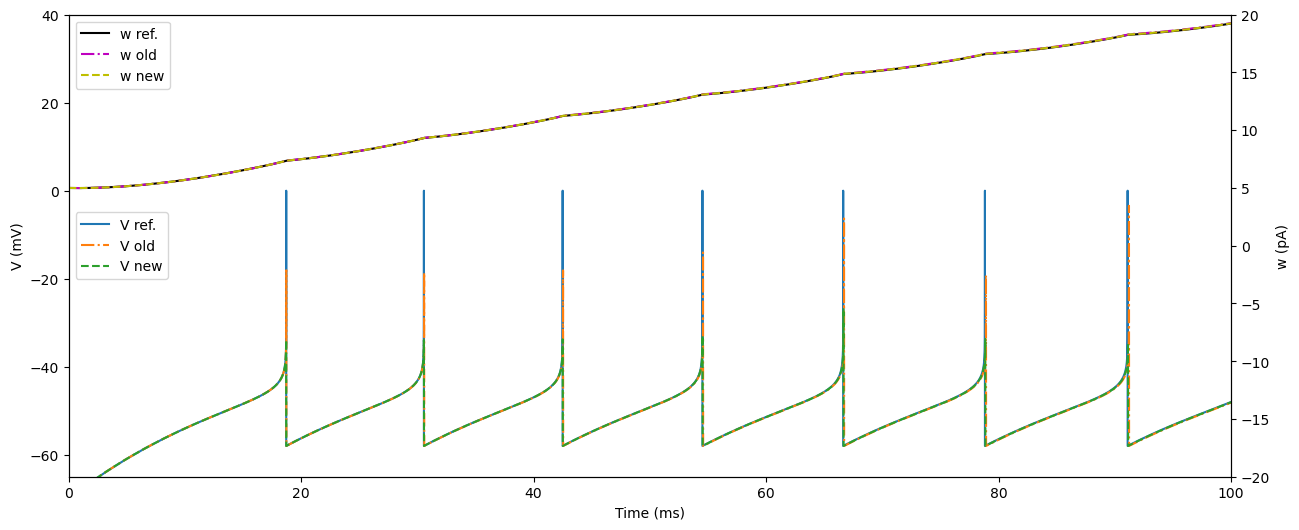

In [8]:
fig, ax = plt.subplots()
ax2 = ax.twinx()

# Plot the potentials
ax.plot(t_ref, y_ref[:, 0], linestyle="-", label="V ref.")
ax.plot(t_old, y_old[:, 0], linestyle="-.", label="V old")
ax.plot(t_new, y_new[:, 0], linestyle="--", label="V new")

# Plot the adaptation variables
ax2.plot(t_ref, y_ref[:, 1], linestyle="-", c="k", label="w ref.")
ax2.plot(t_old, y_old[:, 1], linestyle="-.", c="m", label="w old")
ax2.plot(t_new, y_new[:, 1], linestyle="--", c="y", label="w new")

# Show
ax.set_xlim([0.0, simtime])
ax.set_ylim([-65.0, 40.0])
ax.set_xlabel("Time (ms)")
ax.set_ylabel("V (mV)")
ax2.set_ylim([-20.0, 20.0])
ax2.set_ylabel("w (pA)")
ax.legend(loc=6)
ax2.legend(loc=2)
plt.show()

### Zoom in

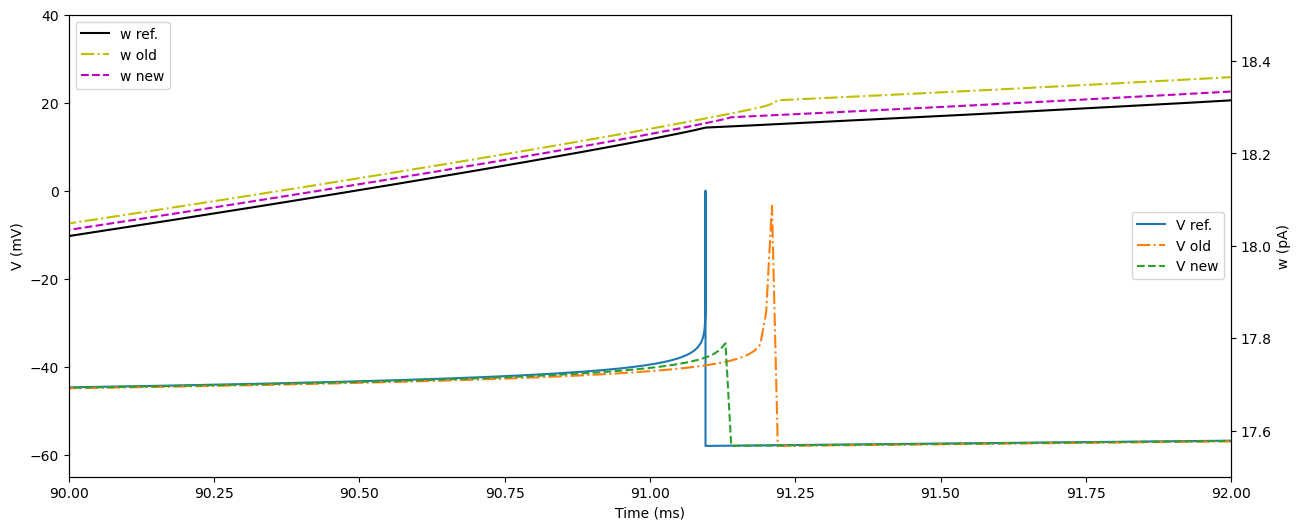

In [9]:
fig, ax = plt.subplots()
ax2 = ax.twinx()

# Plot the potentials
ax.plot(t_ref, y_ref[:, 0], linestyle="-", label="V ref.")
ax.plot(t_old, y_old[:, 0], linestyle="-.", label="V old")
ax.plot(t_new, y_new[:, 0], linestyle="--", label="V new")

# Plot the adaptation variables
ax2.plot(t_ref, y_ref[:, 1], linestyle="-", c="k", label="w ref.")
ax2.plot(t_old, y_old[:, 1], linestyle="-.", c="y", label="w old")
ax2.plot(t_new, y_new[:, 1], linestyle="--", c="m", label="w new")

ax.set_xlim([90.0, 92.0])
ax.set_ylim([-65.0, 40.0])
ax.set_xlabel("Time (ms)")
ax.set_ylabel("V (mV)")
ax2.set_ylim([17.5, 18.5])
ax2.set_ylabel("w (pA)")
ax.legend(loc=5)
ax2.legend(loc=2)
plt.show()

### Compare properties at spike times

In [10]:
print("spike times:\n-----------")
print("ref", np.around(s_ref, 3))  # ref lsodar
print("old", np.around(s_old, 3))
print("new", np.around(s_new, 3))

print("\nV at spike time:\n---------------")
print("ref", np.around(vs_ref, 3))  # ref lsodar
print("old", np.around(vs_old, 3))
print("new", np.around(vs_new, 3))

print("\nw at spike time:\n---------------")
print("ref", np.around(ws_ref, 3))  # ref lsodar
print("old", np.around(ws_old, 3))
print("new", np.around(ws_new, 3))

spike times:
-----------
ref [18.715 30.561 42.495 54.517 66.626 78.819 91.096]
old [18.73 30.59 42.54 54.58 66.71 78.92 91.22]
new [18.72 30.57 42.51 54.54 66.66 78.86 91.14]

V at spike time:
---------------
ref [0.006 0.03  0.025 0.036 0.033 0.031 0.041]
old [ 6.128  5.615  6.107 10.186 17.895  4.997 20.766]
new [32413643.009 32591616.326 35974587.74  51016349.64  77907589.627
 37451353.635 11279320.152]

w at spike time:
---------------
ref [ 7.359  9.328 11.235 13.08  14.864 16.589 18.256]
old [ 7.367  9.344 11.258 13.111 14.906 16.637 18.315]
new [ 7.362  9.334 11.244 13.093 14.883 16.611 18.278]


### Size of minimal integration timestep

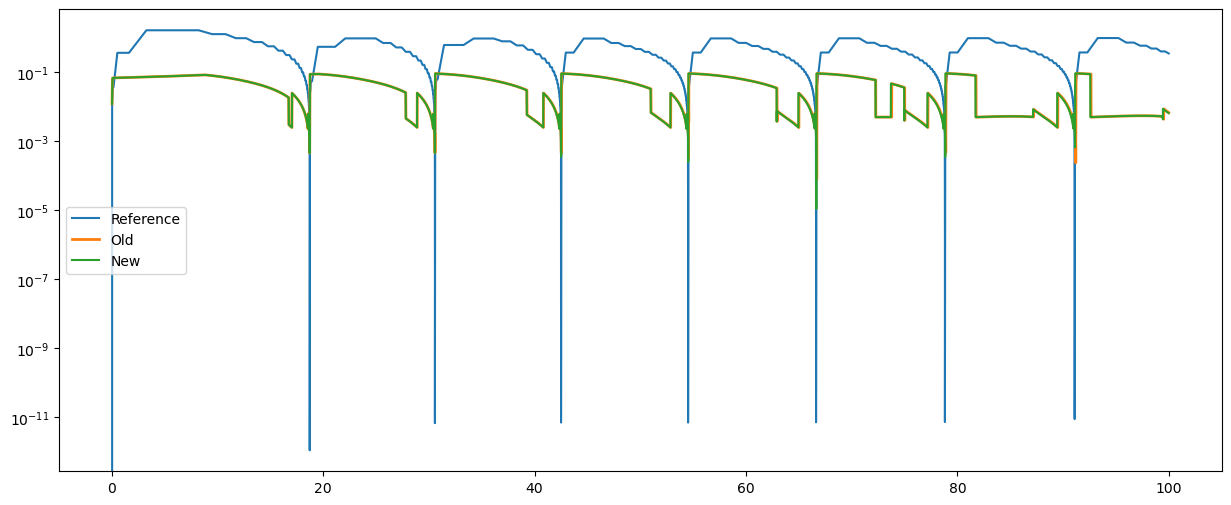

In [11]:
plt.semilogy(t_ref, h_ref, label="Reference")
plt.semilogy(t_old[1:], [d["hu"] for d in fo_old], linewidth=2, label="Old")
plt.semilogy(t_new[1:], [d["hu"] for d in fo_new], label="New")

plt.legend(loc=6)
plt.show();

## Convergence towards LSODAR reference with step size
### Zoom out

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6691731905434D+02   r2 =  0.4368716407574D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6691731905434D+02   r2 =  0.4368716407574D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6691731905434D+02   r2 =  0.4368716407574D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6691731905434D+02   r2 =  0.4368716407574D-14


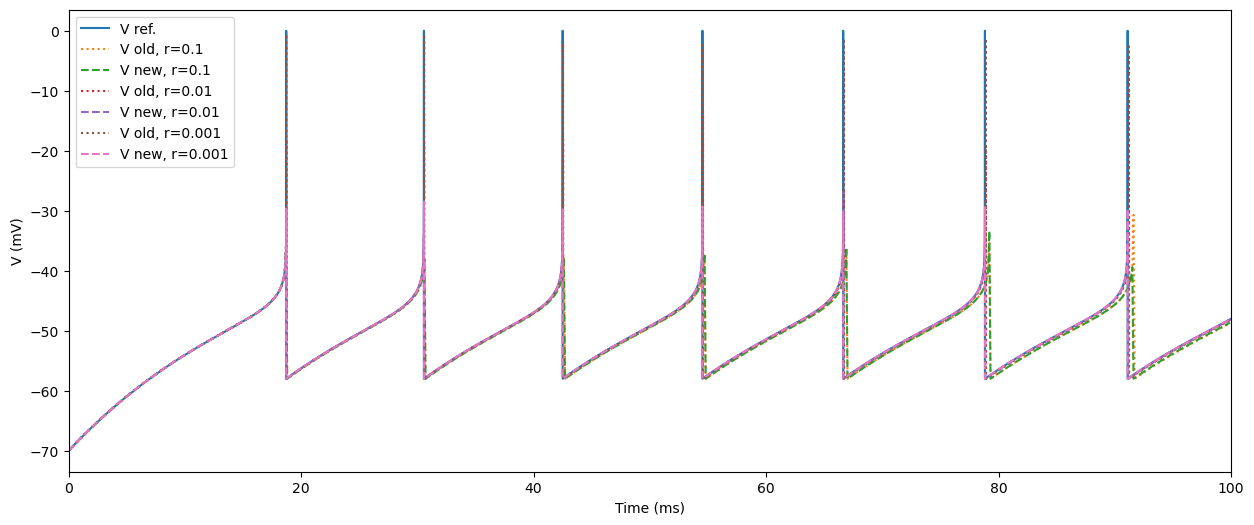

In [12]:
plt.plot(t_ref, y_ref[:, 0], label="V ref.")
resolutions = (0.1, 0.01, 0.001)
di_res = {}

for resolution in resolutions:
    t_old, y_old, _, _, _, _ = scipy_aeif(p, rhs_aeif_old, simtime, resolution)
    t_new, y_new, _, _, _, _ = scipy_aeif(p, rhs_aeif_new, simtime, resolution)
    di_res[resolution] = (t_old, y_old, t_new, y_new)
    plt.plot(t_old, y_old[:, 0], linestyle=":", label="V old, r={}".format(resolution))
    plt.plot(t_new, y_new[:, 0], linestyle="--", linewidth=1.5, label="V new, r={}".format(resolution))
plt.xlim(0.0, simtime)
plt.xlabel("Time (ms)")
plt.ylabel("V (mV)")
plt.legend(loc=2)
plt.show();

### Zoom in

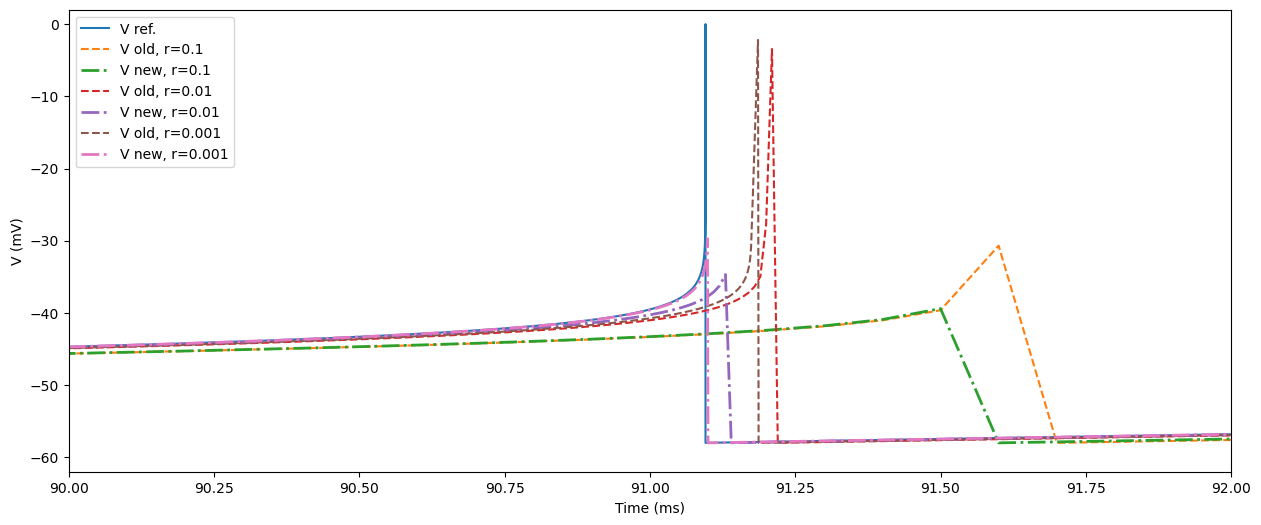

In [13]:
plt.plot(t_ref, y_ref[:, 0], label="V ref.")
for resolution in resolutions:
    t_old, y_old = di_res[resolution][:2]
    t_new, y_new = di_res[resolution][2:]
    plt.plot(t_old, y_old[:, 0], linestyle="--", label="V old, r={}".format(resolution))
    plt.plot(t_new, y_new[:, 0], linestyle="-.", linewidth=2.0, label="V new, r={}".format(resolution))
plt.xlim(90.0, 92.0)
plt.ylim([-62.0, 2.0])
plt.xlabel("Time (ms)")
plt.ylabel("V (mV)")
plt.legend(loc=2)
plt.show();

-----------------------------
### License

This file is part of NEST. Copyright (C) 2004 The NEST Initiative

NEST is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 2 of the License, or (at your option) any later version.

NEST is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details.